In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential, initializers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LSTM, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sn

In [ ]:
# from google.colab import drive (uncomment this if run from colab)
# drive.mount('/content/drive')

In [2]:
# Change the path to the folder of the dataset and the h5 file
path = "./cifar-100-python/"

# Pre-Processing

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# unloading datasets to train, test and meta (labels)
meta = unpickle(path + 'meta')
train = unpickle(path + 'train')
test = unpickle(path + 'test')

In [5]:
# gathering the list of labels
labels = list(meta[b'fine_label_names'])

## Splitting the dataset to train, test and validation for training

In [6]:
y_train = to_categorical(train[b'fine_labels'], len(labels)) # one hot encoding 
y_test = to_categorical(test[b'fine_labels'], len(labels))
X_train = train[b'data'].reshape(50000, 3, 32, 32).transpose(0,2,3,1)
X_test = test[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, random_state = 1)

## Data augmentation

In [8]:
train_datagen = ImageDataGenerator(horizontal_flip=True)

test_datagen = ImageDataGenerator(horizontal_flip=True)
train_generator =  train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = test_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=True)

# RESNET-14
### Partial blocks (identity and convolutional block) From: https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/

## Defining the model

In [11]:
def identity_block(x, filter):

    x_residual = x

    x = tf.keras.layers.Conv2D(filter, (3, 3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter, (3, 3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Add()([x, x_residual])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [12]:
def convolutional_block(x, filter):

    x_residual = x

    x = tf.keras.layers.Conv2D(filter, (3, 3), padding = 'same', strides = (2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter, (3, 3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x_residual = tf.keras.layers.Conv2D(filter, (1, 1), strides = (2, 2))(x_residual)

    x = tf.keras.layers.Add()([x, x_residual])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [13]:
def ResNet14(shape = (32, 32, 3), classes = 100):

    #input layer
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)

    #Conv block 1
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(x)

    # Hidden layers
    # Conv block 2
    x = identity_block(x, 64)
    x = identity_block(x, 64)


    # Conv block 3   
    x = convolutional_block(x, 128)
    x = identity_block(x, 128)

    # Conv block 4
    x = convolutional_block(x, 512)
    x = identity_block(x, 512)

    x = tf.keras.layers.Dropout(0.2)(x)
    
    #Dense Layer
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x)
    return model


In [14]:
model = ResNet14()

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Fitting the model to training

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

In [17]:
EPOCHS=100
batch_size=32
steps_per_epoch = train_generator.n//batch_size
validation_steps = val_generator.n//batch_size
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator),
                        batch_size = 32,
                        epochs=EPOCHS,
                        validation_data = val_generator,
                        validation_steps = len(val_generator),
                        callbacks = [reduce_lr]
                        )

Epoch 1/100
1250/1250 [==============================] - 56s 28ms/step - loss: 4.1330 - accuracy: 0.0860 - val_loss: 3.6971 - val_accuracy: 0.1234
Epoch 2/100
1250/1250 [==============================] - 33s 27ms/step - loss: 3.1998 - accuracy: 0.2181 - val_loss: 3.0095 - val_accuracy: 0.2544
Epoch 3/100
1250/1250 [==============================] - 32s 25ms/step - loss: 2.7488 - accuracy: 0.3026 - val_loss: 3.1033 - val_accuracy: 0.2596
Epoch 4/100
1250/1250 [==============================] - 30s 24ms/step - loss: 2.4190 - accuracy: 0.3720 - val_loss: 2.5840 - val_accuracy: 0.3426
Epoch 5/100
1250/1250 [==============================] - 30s 24ms/step - loss: 2.1581 - accuracy: 0.4263 - val_loss: 2.7224 - val_accuracy: 0.3451
Epoch 6/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.9378 - accuracy: 0.4719 - val_loss: 2.2796 - val_accuracy: 0.4069
Epoch 7/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.7534 - accuracy: 0.5167 - val_loss: 2

## Saving the model

In [18]:
model.save("Group73_ResNet14_model.h5")

C:\Users\Ananda\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Loading the saved model

In [9]:
model = keras.models.load_model("Group73_ResNet14_model.h5",compile=True)

# Results

In [10]:
resnet_pred = model.evaluate(test_generator, batch_size = 32)

313/313 [==============================] - 6s 8ms/step - loss: 3.8439 - accuracy: 0.5629


In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 3.859851598739624 / Test accuracy: 0.5648999810218811


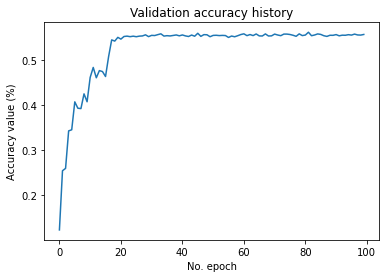

In [22]:
#Plot of Validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

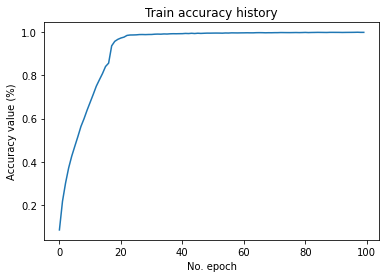

In [23]:
# plot of train accuracy
plt.plot(history.history['accuracy'])
plt.title('Train accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

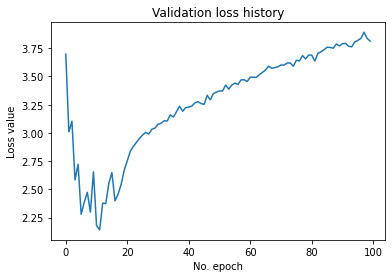

In [24]:
# plot of validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

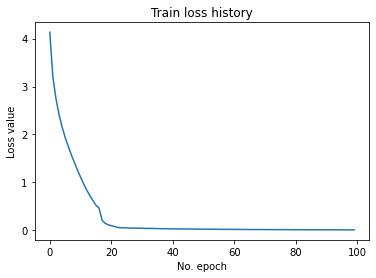

In [25]:
# plot of trian loss
plt.plot(history.history['loss'])
plt.title('Train loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

## Running the trained model on test set

In [26]:
# getting the test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 3.859849214553833 / Test accuracy: 0.5648999810218811


Text(0.5, 1.0, "b'lion'")

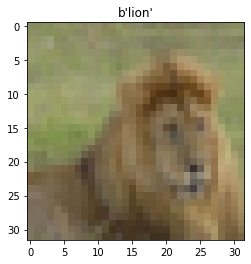

In [27]:
# printing example of predicted lable and actual image
test_index = 15

img = X_test[test_index]
plt.imshow(img)
plt.title(labels[np.argmax(model.predict(img.reshape(1,32,32,3)))])

In [28]:
Y_pred = model.predict(X_test)

In [29]:
# results
pred=np.argmax(Y_pred,axis=1)
ground = np.argmax(y_test,axis=1)
print(classification_report(ground,pred))
print(accuracy_score(ground, pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       100
           1       0.72      0.68      0.70       100
           2       0.37      0.40      0.39       100
           3       0.36      0.38      0.37       100
           4       0.39      0.45      0.42       100
           5       0.53      0.58      0.55       100
           6       0.63      0.65      0.64       100
           7       0.62      0.64      0.63       100
           8       0.82      0.73      0.77       100
           9       0.67      0.63      0.65       100
          10       0.38      0.33      0.35       100
          11       0.40      0.39      0.39       100
          12       0.57      0.60      0.59       100
          13       0.46      0.46      0.46       100
          14       0.56      0.47      0.51       100
          15       0.53      0.49      0.51       100
          16       0.57      0.65      0.60       100
          17       0.68    

<AxesSubplot:>

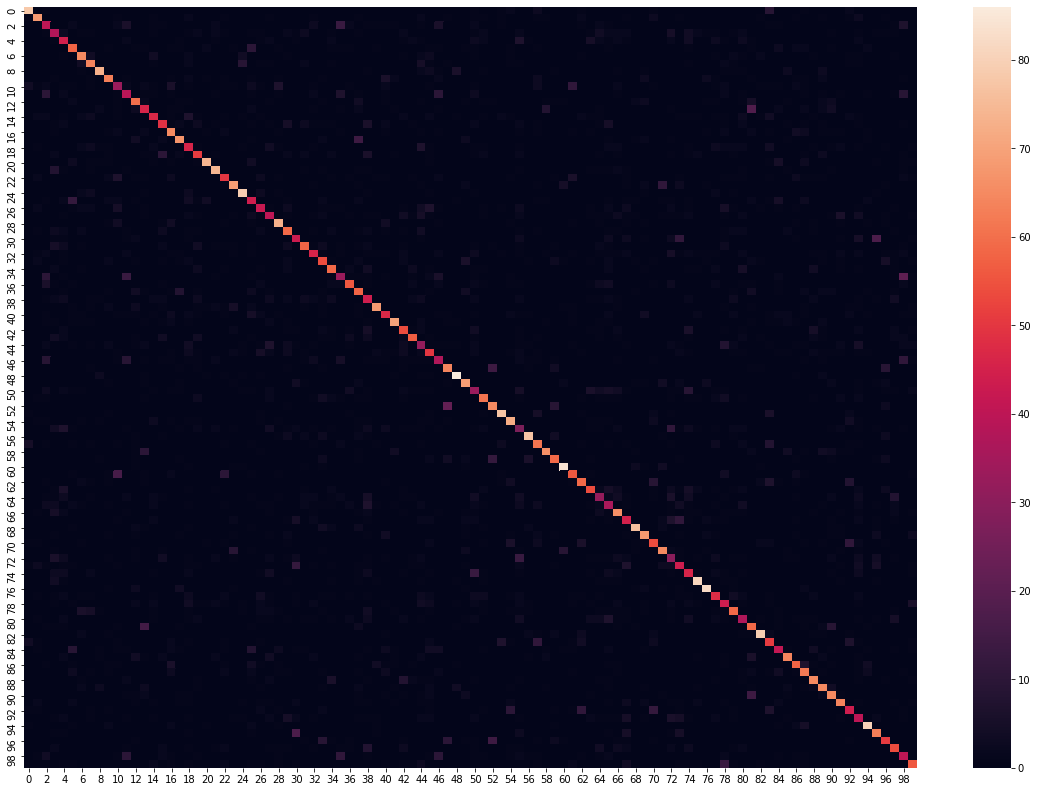

In [30]:
#confusion matrix
plt.figure(figsize = (20,14))
sn.heatmap(confusion_matrix(ground, pred))